IMPORT LIBRARIES

In [1]:
# Import libraries
import os
import librosa
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import sounddevice as sd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
from random import shuffle
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


TASK 1: Read wav files and create numpy array of them

    TASK 1.1 Get voiced parts

In [2]:
def get_auto_correlation(clip, FRAME_SIZE = 100):
    bins = np.zeros(FRAME_SIZE)
    for i in range(0, FRAME_SIZE):
        for j in range(0, FRAME_SIZE-i):
            bins[i] += (clip[j] * clip[j+i])
    return bins

#doesnt work perfectly - it doesnt connect all parts of audio
def get_voiced_parts(clip, sr, FRAME_SIZE = 100):
    IS_CURR_VOICED = False

    MAX_NUM_FRAMES = 25
    START_NUM_FRAMES = 20
    MIN_NUM_OF_SAMPLES_IN_SEGMENT = 0.2 * sr
    MIN_RMS = 0.05

    voiced_counter = 0
    start_of_segment = -1
    end_of_segment = -1
    end_of_checking = (len(clip)//FRAME_SIZE-1) * FRAME_SIZE

    for i in range(0, end_of_checking, FRAME_SIZE):
        #for each frame
        bins = np.zeros(FRAME_SIZE)
        bins = get_auto_correlation(clip[i:i+FRAME_SIZE], FRAME_SIZE)
        #plt.stem(bins)
        maximums = np.diff(argrelextrema(bins, np.greater))
        median_maximums = np.median(maximums)
        #if median maximus in some boudaries
        if median_maximums >= 7 and median_maximums <= 20 and np.std(maximums) < 7:
            voiced_counter = min(voiced_counter + 1, MAX_NUM_FRAMES)

            if not IS_CURR_VOICED:
                voiced_counter = START_NUM_FRAMES
                IS_CURR_VOICED = True
                start_of_segment = i
        else:
            voiced_counter = max(0, voiced_counter - 1)

            if voiced_counter == 0 and IS_CURR_VOICED:
                IS_CURR_VOICED = False
                end_of_segment = i
                #if too short
                if end_of_segment - start_of_segment < MIN_NUM_OF_SAMPLES_IN_SEGMENT:
                    continue 
                rms = np.sqrt(np.mean(clip[start_of_segment:end_of_segment]**2))
                if rms < MIN_RMS:
                    continue
                return clip[start_of_segment: end_of_segment]

    end_of_segment = len(clip)
    
    if IS_CURR_VOICED and ((end_of_segment - start_of_segment) > MIN_NUM_OF_SAMPLES_IN_SEGMENT):
        return clip[start_of_segment: end_of_segment]       
    return None

    

TESTING !!!!

/home/larsvonk/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/larsvonk/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.1375 1.5625
2357


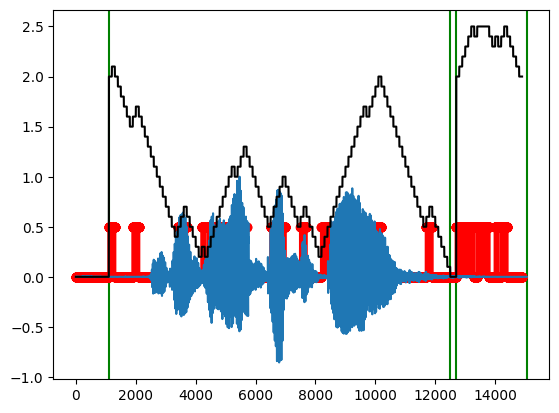

In [3]:
#trying to detect spoken parts with outocorrleation
new_sr = 8000
clip, sr = librosa.load("../data/divide/anja_3.wav")
clip = librosa.resample(clip, orig_sr=sr, target_sr=new_sr)
clip = librosa.to_mono(clip)
clip = librosa.util.normalize(clip)

IS_CURR_VOICED = False

MAX_NUM_FRAMES = 25
START_NUM_FRAMES = 20
MIN_NUM_OF_SAMPLES_IN_SEGMENT = 0.2 * new_sr
MIN_RMS = 0.05

voiced_counter = 0
start_of_segment = -1
end_of_segment = -1
FRAME_SIZE = 100
len_clip_in_frames = len(clip) // FRAME_SIZE - 1
end_of_checking = len_clip_in_frames * FRAME_SIZE
out = np.zeros(len_clip_in_frames)
curr_voiced_over_time = np.zeros(len_clip_in_frames)

for i in range(0, end_of_checking, FRAME_SIZE):
    #for each frame
    bins = np.zeros(FRAME_SIZE)
    bins = get_auto_correlation(clip[i:i+FRAME_SIZE], FRAME_SIZE)
    #plt.stem(bins)
    maximums = np.diff(argrelextrema(bins, np.greater))
    median_maximums = np.median(maximums)
    #if median maximus in some boudaries
    if median_maximums >= 7 and median_maximums <= 20 and np.std(maximums) < 7:
        out[i//FRAME_SIZE] = 1
        voiced_counter = min(voiced_counter + 1,MAX_NUM_FRAMES)
        if  not IS_CURR_VOICED:
            voiced_counter = START_NUM_FRAMES
            IS_CURR_VOICED = True
            start_of_segment = i
    else:
        voiced_counter = max(0, voiced_counter-1)

        if voiced_counter == 0 and IS_CURR_VOICED:
            IS_CURR_VOICED = False
            end_of_segment = i
            #if too short
            if end_of_segment - start_of_segment < MIN_NUM_OF_SAMPLES_IN_SEGMENT:
                continue

            rms = np.sqrt(np.mean(clip[start_of_segment:end_of_segment]**2))
            if rms < MIN_RMS:
                continue

            a = clip[start_of_segment: end_of_segment]
            print(start_of_segment/new_sr, end_of_segment/new_sr)
            plt.axvline(start_of_segment, color='g')
            plt.axvline(end_of_segment, color='g')

    #plt.show() 

    curr_voiced_over_time[i//FRAME_SIZE] = voiced_counter
end_of_segment = len(clip)
if IS_CURR_VOICED and ((end_of_segment - start_of_segment) > MIN_NUM_OF_SAMPLES_IN_SEGMENT):
    plt.axvline(start_of_segment, color='g')
    plt.axvline(end_of_segment, color='g')
    print(end_of_segment - start_of_segment)
#print(start_of_segment/new_sr, end_of_segment/new_sr)
plt.stem(np.repeat(out, FRAME_SIZE)*0.5, 'r')
plt.plot(clip)

plt.plot(np.repeat(curr_voiced_over_time, FRAME_SIZE)*0.1, 'k')
sd.play(a, 8000)
#print(maximums)
#plt.plot(clip)

    TASK 1.2 Normalize between -1 and 1

TASK 2. FEATURE EXTRACTION

    TASK 2.1 Preemphasis filter

In [4]:
def add_preemphasis_filter(x, coeff=0.95):
    x = librosa.effects.preemphasis(x, coef = coeff)
    return x

    TASK 2.2 Create MFCC of samles of uniform size (30, 80)

In [5]:
def get_2d_features(y, sr = 8000, wanted_width = 40):
    y = add_preemphasis_filter(y)
    #20 row mfcc, 20 row delta mfcc, 1 row pitch...
    windows_size = len(y) // (wanted_width - 1)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mels=20, n_fft=300, hop_length=windows_size, window='hamming')
    delta_mfcc = librosa.feature.delta(mfcc)
    mfcc = np.concatenate((mfcc, delta_mfcc, ), axis=0)
    return mfcc

In [6]:
def get_1d_features(y, sr = 8000, wanted_width = 5):
    windows_size = len(y)//(wanted_width - 1)
    #coeffients of polynomial fitting frequency information over time
    polly_coeff = librosa.feature.poly_features(y=y, sr=sr, order=0, n_fft=1024, hop_length=windows_size, window='hamming')[0]
    #how many times do signal cross zero
    zero_cross = librosa.feature.zero_crossing_rate(y=y, frame_length=1024, hop_length=windows_size)[0]
    #tone vs noise level in each windows
    tone_vs_noise = librosa.feature.spectral_flatness(y=y, n_fft=1024, hop_length=windows_size)[0]
    
    return np.concatenate((polly_coeff, zero_cross, tone_vs_noise), axis=0)

        TESTING!

[1.96106221 2.7488533  0.65854726 0.09661637 0.32039525 0.22558594
 0.5        0.52734375 0.59082031 0.30566406 0.14811699 0.03635823
 0.0411064  0.3276951  0.31542945]


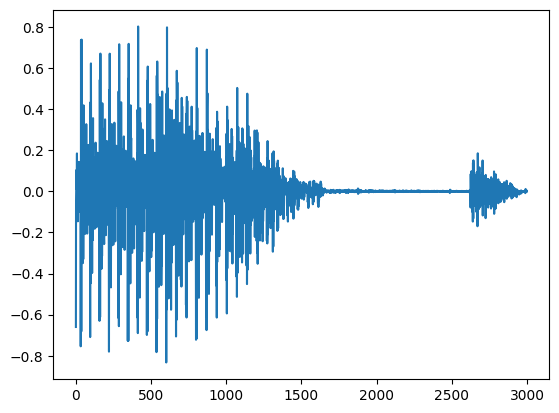

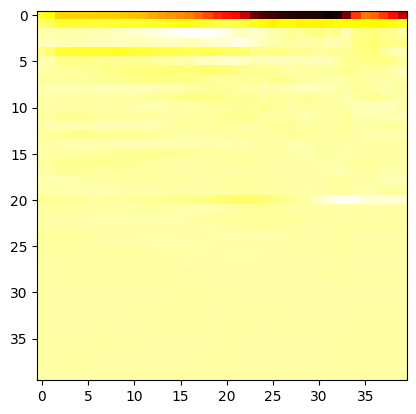

In [7]:
new_sr = 8000
clip, sr = librosa.load("../data/eight/luka_3.wav")
clip = librosa.resample(clip, orig_sr=sr, target_sr=new_sr)
clip = librosa.to_mono(clip)
clip = librosa.util.normalize(clip)
clip = get_voiced_parts(clip, new_sr)
clip = add_preemphasis_filter(clip)
features = get_2d_features(clip, new_sr)


print(get_1d_features(clip))

sd.play(clip, new_sr)
sd.wait()
plt.plot(clip)
plt.show()
plt.imshow(features, cmap='hot', interpolation='nearest')

    TASK 2.3 Other feutures -TODO

Here we see the example main function to create train/validate and test set

In [8]:
def make_train_data(directory):
    training_data = []
    labels = []
    eye_in = 0
    NUM_CATEGORIES = len(os.listdir(directory))
    #get all subdirectories in directory
    for category in os.listdir(directory):
        print(category)
        labels.append(category)
        path = os.path.join(directory, category)
        for file in os.listdir(path):
            try:
                #Fs, audio = wavfile.read(os.path.join(path, file))
                clip, sr = librosa.load(os.path.join(path, file))
                clip = librosa.resample(clip, orig_sr=sr, target_sr=8000)
                clip = librosa.to_mono(clip)

                clip = librosa.util.normalize(clip)
                clip = get_voiced_parts(clip,8000)

                if(clip is None):
                    print("{} not good".format(os.path.join(path, file)))
                    continue

                features_2d = get_2d_features(clip)
                features_1d = get_1d_features(clip)

                training_data.append([features_2d, features_1d, np.eye(NUM_CATEGORIES)[eye_in]])
            except Exception as e:
                print(e)
                pass
        eye_in += 1
    np.random.shuffle(training_data)
    training_data = np.array(training_data, dtype=object)

    # Split the features and labels
    X_2d = np.array([i[0] for i in training_data])
    X_1d = np.array([i[1] for i in training_data])
    y = np.array([i[2] for i in training_data])

    # Split the data into training and test sets
    X_2d_train, X_2d_test, X_1d_train, X_1d_test, y_train, y_test = train_test_split(X_2d, X_1d, y, test_size=0.15, random_state=42)

    return np.array(labels), X_2d_train, X_2d_test, X_1d_train, X_1d_test, y_train, y_test

#X_2d_train, X_2d_test, X_1d_train, X_1d_test, y_train, y_test = make_train_data(os.path.join(os.getcwd(), "..", "data"))


Train reduced data

In [9]:
labels, X_2d_train, X_2d_test, X_1d_train, X_1d_test, y_train, y_test = make_train_data(os.path.join(os.getcwd(), "..", "reduced_data"))

np.savez("training_data_reduced.npz", labels=labels, X_2d_train=X_2d_train, X_2d_test=X_2d_test, X_1d_train=X_1d_train, X_1d_test=X_1d_test, y_train=y_train, y_test=y_test)

zero


/home/larsvonk/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/larsvonk/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/home/larsvonk/Projects/IASRProject/src/../reduced_data/zero/theo_48.wav not good
two
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/jackson_7.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/jackson_12.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/theo_10.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/nicolas_2.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/nicolas_27.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/theo_6.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/theo_4.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/jackson_9.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/theo_45.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/yweweler_24.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/theo_12.wav not good
/home/lar

Train all data

In [10]:
labels, X_2d_train, X_2d_test, X_1d_train, X_1d_test, y_train, y_test = make_train_data(os.path.join(os.getcwd(), "..", "reduced_data"))

np.savez("training_data.npz", labels=labels, X_2d_train=X_2d_train, X_2d_test=X_2d_test, X_1d_train=X_1d_train, X_1d_test=X_1d_test, y_train=y_train, y_test=y_test)

zero
/home/larsvonk/Projects/IASRProject/src/../reduced_data/zero/theo_48.wav not good
two
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/jackson_7.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/jackson_12.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/theo_10.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/nicolas_2.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/nicolas_27.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/theo_6.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/theo_4.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/jackson_9.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/theo_45.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/yweweler_24.wav not good
/home/larsvonk/Projects/IASRProject/src/../reduced_data/two/theo_12.wav not good
/hom

Task 3. Neural network

In [11]:
#Load reduced set
labels, X_2d_train, X_2d_test, X_1d_train,  X_1d_test, y_train,y_test = np.load("training_data_reduced.npz", allow_pickle=True).values()

In [12]:
#Load whole set
labels, X_2d_train, X_2d_test, X_1d_train,  X_1d_test, y_train,y_test = np.load("training_data.npz", allow_pickle=True).values()

In [13]:
print(y_train.shape)
print(X_2d_train.shape)
print(X_1d_train.shape)

print(y_test.shape)
print(X_2d_test.shape)
print(X_1d_test.shape)
print(labels)

(540, 5)
(540, 40, 40)
(540, 15)
(96, 5)
(96, 40, 40)
(96, 15)
['zero' 'two' 'four' 'six' 'plus']


 Example show of random feature vector

[2.35647166 1.47964263 0.79304284 0.33400769 0.2697454  0.05664062
 0.15136719 0.46386719 0.78515625 0.39160156 0.01666369 0.01152418
 0.2137928  0.10055927 0.17641543]
two


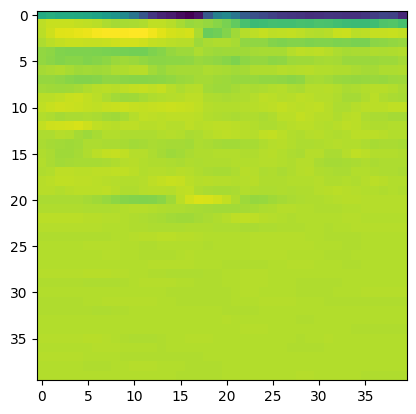

In [14]:
INDEX = 2
plt.imshow(X_2d_train[INDEX])
print(X_1d_train[INDEX])
print(labels[np.argmax(y_test[INDEX])])

In [15]:
# Define the missing variables
height = 40
width = 40
number_of_linear_values = 15
number_of_classes = len(labels)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 7)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3)

        x = torch.randn(height,width).view(-1,1,height,width)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, number_of_classes) # Adjusted to match the number of classes

    def convs(self, x):
        x = F.max_pool2d(F.leaky_relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.leaky_relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.leaky_relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        #now new data is added to linear layers
        x = x.view(-1, self._to_linear)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)


In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")
    
os.environ['CUDA_VISIBLE_DEVICES']='2, 3'
net = Net().to(device)

CPU


In [17]:
#optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.001) #learning rate
err_f = nn.MSELoss()

train_2d_X = torch.Tensor(X_2d_train).view(-1, 40, 40)
train_1d_X = torch.Tensor(X_1d_train)
train_y = torch.Tensor(y_train)

In [18]:
# Get the first image from your training data
#first_image = train_X[0]
#print(first_image.shape) #TODO: can remove this line, added for testing

# Get the height and width of the first image
height, width = train_2d_X.shape[1], train_2d_X.shape[2]

#training
BATCH_SIZE = 16
EPOH = 700
N = 5 #how ofter we print loss
EPSILON = 0.0001 #if loss different under this

running_loss = 0.0
all_losses = [100]
for epoch in range(EPOH):
    for i in range(0, len(train_2d_X), BATCH_SIZE):
        batch_X = train_2d_X[i:i+BATCH_SIZE].view(-1,1,height,width)
        batch_y = train_y[i:i+BATCH_SIZE]

        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        net.zero_grad() #zero gradient
        out = net(batch_X)
        err = err_f(out, batch_y)
        err.backward()
        optimizer.step()
        
        running_loss += err.item()
    # Generate a permutation of indices
    perm = torch.randperm(train_2d_X.size(0))
    # Use the permutation to shuffle the tensors
    train_2d_X = train_2d_X[perm]
    train_y = train_y[perm]

    if epoch % N == N-1:
        print("EPOH {}/{} loss: {}".format(epoch+1, EPOH, running_loss/N))
        all_losses.insert(0, running_loss/N)
        if all_losses[1]-all_losses[0] < EPSILON: #less than percent impromvenet
            break
        running_loss = 0.0
        clear_output(wait=True)   

EPOH 40/700 loss: 0.00022141669343227476


In [19]:
# Save the reduced model
torch.save(net.state_dict(), 'model_reduced.pth')

In [20]:
# Save the whole model
torch.save(net.state_dict(), 'model.pth')

###   Run the mode over training set

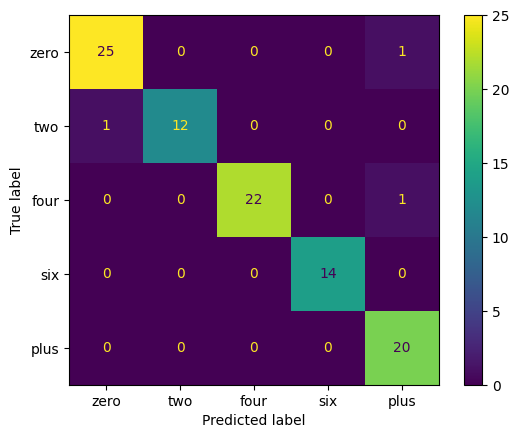

Accuracy: 96.875%
Error: 3.125%


In [26]:
missclassified = 0
actual = []
predicted = []

for i in range(0, y_test.shape[0]):
    with torch.no_grad():
        data_2d = torch.Tensor(X_2d_test[i]).view(-1,1,height,width).to(device) #flatten
        #data_2d = data_2d.view(-1,1,height,width)
        output = net(data_2d).to(device)
        
        classification = torch.argmax(output)
        base_truth = np.argmax(y_test[i])

        predicted.append(classification)
        actual.append(base_truth)

        if base_truth != classification:
            missclassified += 1

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
cm_display.plot()
plt.show()

error = missclassified / y_test.shape[0]

print("Accuracy: {}%".format((1 - error) * 100))
print("Error: {}%".format(error * 100))

# Record new data

In [ ]:
import os
import sounddevice as sd
from scipy.io import wavfile 

freq = 44100
duration = 4

try:
    recording = sd.rec(int(duration * freq), samplerate=freq, channels=2)
    print("Recording: start speaking...")

    sd.wait()

    filepath = os.path.join(os.getcwd(), "..", "input", "input.wav")
    wavfile.write(filepath, freq, recording)  # Fix the function call

except Exception as e:
    print("An error occurred:", e)

Recording: start speaking...


In [ ]:
# Read new data and classify
clip, sr = librosa.load(filepath)
clip = librosa.resample(clip, orig_sr=sr, target_sr=8000)
clip = librosa.to_mono(clip)
clip = librosa.util.normalize(clip)
clip = get_voiced_parts(clip,8000)
clip = add_preemphasis_filter(clip)
features = get_2d_features(clip, 8000)
features = torch.Tensor(features).view(-1,1,height,width)
features = features.to(device)
out = net(features)
classification = torch.argmax(out)
print(labels[classification])

six
